<center><font size=4 face="Caliber"> QF608 Reserach Method Individual Assignment
    
<center><font size=6 face="Caliber"> Endogeneity of Commodity Price in Freight Cost

<center><font size=4 >Zhu Zhizhong
    

## Introduction

BDI, Baltic Dry Index, measures the cost of shipping goods around the world. Therefore, it should has a positive correlation with the demand of commodity and freight, thus affecting their prices. 
Our report is basing on the paper "Endogeneity of Commodity Price in Freight Cost", and further analyzed BDI's impact on both iron ore price and freight price. We used the same dual market system as the paper did, and looked at the changes when BDI is included.

The main purpose of this report is to answer 2 key questions: 

1. Is BDI redundant or important in explaning ore price and freight cost;
2. Is there still endogeneity issue in the equation of freight cost;

In section 2, the report will answer the first question by looking at regression of ore price with and without BDI, and in section 3, the second question will be answered by looking at panal regression for freight price and endogneity test.

# Content:

## 1. Data Preparation
* 1.1 Data Cleansing
* 1.2 Data Discription

## 2. Estimation for Iron Ore Price
* 2.1 Mode
* 2.2 Regression results for eq1 and eq2
    * 2.2.1 Conclusion on BDI

## 3. Panal Regression for Freight Price
* 3.1 Model
* 3.2 Regression result for eq3 and eq4
    * 3.2.1 Conclusion on BDI
* 3.3 Endogeneity test
    * 3.3.1 2SLS
    * 3.3.2 Hausman test

## 4. Conclusion

# 1. Data Preparation


## 1.1 Data Cleansing

 Align date format within each data file to month format ('yyyymm') for easy merging.
  
 

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from linearmodels import PanelOLS, IV2SLS

In [3]:
# data end at Apr 2019
BDI_raw = pd.read_csv('data/BDI.csv')
JC1_raw = pd.read_csv('data/JC1.csv')
JC3_raw = pd.read_csv('data/#amended_JC3.csv')
#JC3_raw_old = pd.read_csv('data/JC3.csv')

JC1 = JC1_raw.rename(columns={'yyyymm':'Ym'})[[ 'Ym', 'ore_price', 'growth', 'VIX']]
JC3 = JC3_raw.rename(columns={'date':'Ym'})[['Ym', 'port', 'growth', 'VIX', 'logd', 'logf', 'avefreight','ore_price']]
BDI = BDI_raw.rename(columns={'date':'Ym'})[[ 'BDI', 'Ym']]
#JC3_old = JC3_raw_old.rename(columns={'date':'Ym'})

for i, j in zip([JC1, JC3, BDI], ['JC1', 'JC3', 'BDI']):
    print(j+':',len(i))
    print(list(i.columns),'\n')

JC1: 66
['Ym', 'ore_price', 'growth', 'VIX'] 

JC3: 264
['Ym', 'port', 'growth', 'VIX', 'logd', 'logf', 'avefreight', 'ore_price'] 

BDI: 66
['BDI', 'Ym'] 



## 1.2 Data Discription
 
|DataName|Discription |Len|time range|
|:--|:--|:--|:--|
|JC1| monthly ore price, VIX, growth|66|201312 to 201905|
|JC3| monthly ore price, freight, diatance, ore price by port |264|201312 to 201905|
|BDI| monthly Baltic Dry Index|66 |201312 to 201905|
 
 * BDI data is web crawled from https://tradingeconomics.com/commodity/baltic.

In [4]:
JC1.describe().T

,count,mean,std,min,25%,50%,75%,max
Ym,66.0,201624.500000,161.989197,201312.000,201504.2500,201608.500,201778.750000,201905.00000
ore_price,66.0,72.279830,18.107719,40.500,59.3925,68.415,80.897500,113.39632
growth,66.0,0.005394,0.001456,0.001,0.0050,0.005,0.006000,0.01000
VIX,66.0,15.075606,3.821155,9.510,12.4850,13.975,16.855001,28.43000


In [5]:
JC3.describe().T

,count,mean,std,min,25%,50%,75%,max
Ym,264.0,201624.500000,161.062655,201312.000000,201504.000000,201608.500000,201801.000000,201905.000000
growth,264.0,0.005394,0.001447,0.001000,0.005000,0.005000,0.006000,0.010000
VIX,264.0,15.075606,3.799299,9.510000,12.370000,13.975000,16.950001,28.430000
logd,264.0,8.666316,0.497286,8.183677,8.183886,8.584074,9.066504,9.313438
logf,264.0,5.946294,0.301473,5.087596,5.802118,5.964725,6.173786,6.391917
avefreight,264.0,9.619252,4.887627,2.941667,5.913348,8.178897,12.319167,29.215000
ore_price,264.0,72.279830,18.004146,40.500000,59.090000,68.415000,81.060000,113.396320


In [6]:
BDI.describe().T

,count,mean,std,min,25%,50%,75%,max
BDI,66.0,997.181818,369.136952,317.0,705.00,944.5,1224.25,2277.0
Ym,66.0,201624.500000,161.989197,201312.0,201504.25,201608.5,201778.75,201905.0


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def CorrPlot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

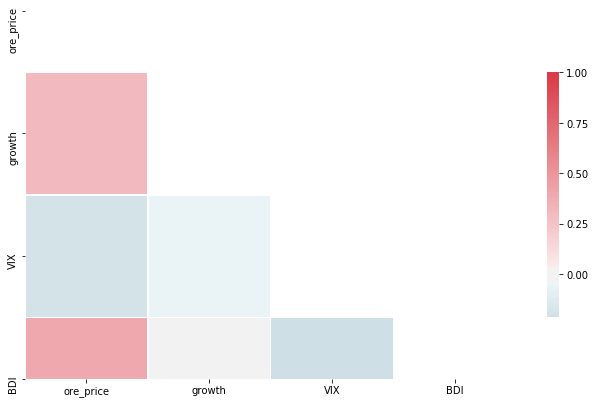

In [22]:
# corr check of JC1
temp = pd.merge(JC1, BDI, how='left', on='Ym').drop(['Ym'], axis=1)
CorrPlot(temp.corr())

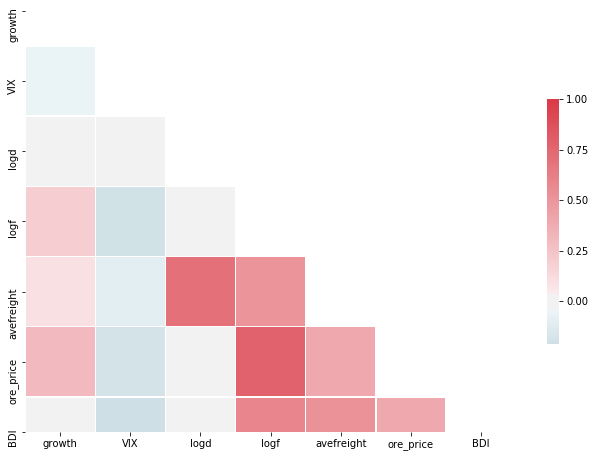

In [23]:
# corr check of JC3
temp = pd.merge(JC3, BDI, how='left', on='Ym').drop(['Ym'], axis=1)
CorrPlot(temp.corr())

# 2. Estimation for Iron Ore Price

## 2.1 Model
As stated in paper, we have market-clearing iron ore price form demand and supply equilibrium.

$$
P_{t}^{R}=\theta_{0}+\theta_{1} X_{t}-\theta_{2} V I X_{t}+\epsilon_{t}\tag{1}
$$
Assuming $BDI$ is mistakenly left out in demand of iron ore, we should alternatively have below euqation for iron ore price:
$$
P_{t}^{R}=\theta_{0}+\theta_{1} X_{t}-\theta_{2} V I X_{t}+\theta_{3}BDI_{t}+\epsilon_{t}\tag{2}
$$

where,
* $P_{t}^{R}$ is iron ore price in USD per dry metric ton;
* $ X_{t}$ is China's industrial production or overall economic activity growth rate;
* $ V I X_{t}$ is CBOE Volatility Index;
* $BDI_t$ is Baltic Dry Index;

## 2.2 Regression results for eq1 and eq2
After regression for eq.(1) and eq.(2), we have below results:

||Estimated<br> Coefficient|Standard<br> Error| t-stats|p-Value |
|:-:|:-:|:-:|:-:|:-:|
|$\theta_{0}$ | 64.994*** | 11.753 | 5.530 | 0.000 |
|$\theta_{1}$ | 3624.57** | 1646.73 | 2.201 | 0.028 |
|$\theta_{2}$ | 0.814* | 0.421 | 1.931 | 0.053 |
| F-statistic  | 4.641** |  p-Value  | 0.013 | 
|$\text {Adj. }R^{2}$ | 0.092 | | | 
|ADF-statistics <br>Residual Error | -2.761* | p-Value| 0.064 |

<!-- \begin{equation}\begin{array}{|c|clll|}
\hline & \begin{array}{l}
\text { Estimated } \\
\text { Coefficient }
\end{array} & \begin{array}{l}
\text { Standard } \\
\text { Error }
\end{array} & \text { t-stats } & \text { p-Value } \\
\hline \theta_{0} & 64.994 & 11.753 & 5.530 & 0.000 \\
\theta_{1} & 3624.57 & 1646.73 & 2.201 & 0.028 \\
\theta_{2} & 0.814 & 0.421 & 1.931 & 0.053 \\
\hline \text { F-statistic } & 4.641 & \text { p-Value } & 0.013 & \\
\hline \text { Adj. } R^{2} & 0.092 & & & \\
\hline \text { ADF-statistics } & -2.761 & \text { p-Value } & 0.064 & \\
\text { Residual Error } & & & & \\
\hline
\end{array}\end{equation} -->
<center>Table 1 Linear Regression of Iron Ore Prices on Variable based on Eq.(1)    <br/>The statistics are computed using White's HCCME (1980).

||Estimated<br> Coefficient|Standard<br> Error| t-stats|p-Value |
|:-:|:-:|:-:|:-:|:-:|
|$ \theta_{0}$ | 39.10*** | 12.379 | 3.158 | 0.002| 
|$\theta_{1}$ | 3754.96** | 1527.034 | 2.459 | 0.014 |
|$\theta_{2}$ | 0.417 | 0.410 | 1.018 | 0.309 |
|$\theta_{3}$ | 0.0193*** | 0.005 | 4.012 | 0.000| 
|F-statistic  | 9.084*** |p-Value  | 0.000 | 
|$Adj.  R^2$ | 0.232 | | | 
|ADF-statistics  | -2.672* |p-Value  | 0.079 | 
    
<!-- \begin{equation}\begin{array}{|c|clll|}
\hline & \begin{array}{l}
\text { Estimated } \\
\text { Coefficient }
\end{array} & \begin{array}{l}
\text { Standard } \\
\text { Error }
\end{array} & \text { t-stats } & \text { p-Value } \\
\hline \theta_{0} & 39.10 & 12.379 & 3.158 & 0.002 \\
\theta_{1} & 3754.96 & 1527.034 & 2.459 & 0.014 \\
\theta_{2} & 0.417 & 0.410 & 1.018 & 0.309 \\
\theta_{3} & 0.0193 & 0.005 & 4.012 & 0.000 \\
\hline \text { F-statistic } & 9.084 & \text { p-Value } & 0.000 & \\
\hline \text { Adj. } R^{2} & 0.232 & & & \\
\hline \text { ADF-statistics } & -2.672 & \text { p-Value } & 0.079 & \\
\text { Residual Error } & & & & \\
\hline
\end{array}\end{equation} -->
<center>  Table 2 Linear Regression of Iron Ore Prices on Variable based on Eq.(2)    <br/>The statistics are computed using White's HCCME (1980).

## 2.2.1 Conclusion on BDI

From table2 and table3 we conslude that BDI is an important variable in explaining ore_price in that:
- in table 2 BDI has a significant P value of 0.000, thus we need to reject H0: $\theta_3=0$ at 0.1% significance level, and arrive at a significant non-zero coefficient conclusion; 
    
- By adding BDI into regressor, $adjusted\ R^2$ of model increased from 0.092 in table 1 to 0.232 in table 2, indicating the model has a better explaining power after including BDI;

Furthermore, BDI has a positive correlation with iron ore price. For unit increase in BDI, ore price would rise by 0.0193 Dollar.


In [24]:
# using HC1 we are able to replicate origonal result in paper, but HC1 refers to MacKinnon and White’s (1985) heteroskedasticity robust standard errors.
# ref: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.HC1_se.html#statsmodels.regression.linear_model.RegressionResults.HC1_se
def table3(JC1, x_col = ['growth','VIX']):
    ## eq3, iron price vs X, VIX
    ## X: growth
    x_col += ['constant']
    Reg1 = JC1.copy()
    Reg1['constant'] = 1
    y_col = ['ore_price']
    Reg1_rst = sm.OLS(Reg1[y_col], Reg1[x_col]).fit(cov_type='HC1')
    adf_rst = sm.tsa.stattools.adfuller(Reg1_rst.resid)
    print('ADF:{}, p_value:{}'.format(adf_rst[0],adf_rst[1]) )
    return Reg1_rst.summary()

In [25]:
# table 3 without BDI
print('Table3, without BDI.\n')
temp = table3(JC1, x_col = ['growth','VIX'])
# if you want to varify result, pls check temp
temp

Table3, without BDI.

ADF:-2.7611913922116966, p_value:0.0640346926733462


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ore_price   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.641
Date:                Sun, 26 Apr 2020   Prob (F-statistic):             0.0132
Time:                        18:22:03   Log-Likelihood:                -280.08
No. Observations:                  66   AIC:                             566.2
Df Residuals:                      63   BIC:                             572.7
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
growth      3624.5659   1646.733      2.201      0.028     397.028    6852.104
VIX           -0.8136      0.421     -1.931      0.053      -1.639       0.012
constant      64.9939     11.753      5.530      0.000      41.959      88.028
==============================================================================
Omnibus:                        7.313   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.228
Skew:                           0.810   Prob(JB):                       0.0270
Kurtosis:                       3.056   Cond. No.                     1.08e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# table 3 with BDI
print('Table3, with BDI.\n')
data = pd.merge(JC1, BDI[['BDI','Ym']], on='Ym', how = 'left')
temp = table3(data, x_col = ['growth','VIX', 'BDI'])
# if you want to varify result, pls check temp
temp

Table3, with BDI.

ADF:-2.671626610242966, p_value:0.07907810389869574


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ore_price   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     9.084
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           4.52e-05
Time:                        18:22:04   Log-Likelihood:                -274.04
No. Observations:                  66   AIC:                             556.1
Df Residuals:                      62   BIC:                             564.8
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
growth      3754.9578   1527.034      2.459      0.014     762.027    6747.889
VIX           -0.4170      0.410     -1.018      0.309      -1.220       0.386
BDI            0.0193      0.005      4.012      0.000       0.010       0.029
constant      39.0977     12.379      3.158      0.002      14.835      63.360
==============================================================================
Omnibus:                        9.960   Durbin-Watson:                   0.487
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.314
Skew:                           0.962   Prob(JB):                      0.00576
Kurtosis:                       3.222   Cond. No.                     7.37e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3. Panal Regression for Freight Price

## 3.1 Model 
As concluded from paper, below is the equilibrium freight price from demand and supply.

$$
P_{j t}^{S}=\gamma_{0}+\gamma_{1} X_{t}+\gamma_{2} D_{j}+\gamma_{3} B_{t}-\gamma_{4} P_{t}^{R}+\eta_{j t}\tag{3}
$$

If we include BDI as regressor here, below is the adjusted equation:

$$
P_{j t}^{S}=\gamma_{0}+\gamma_{1} X_{t}+\gamma_{2} D_{j}+\gamma_{3} B_{t}-\gamma_{4} P_{t}^{R} + \gamma_{5}BDI_t+\eta_{j t}\tag{4}
$$

where,
* $P_{j t}^{S}$ is the ship freight spot price rate on route $j$ 
* $X_t$ China's industrial production or overall economic activity growth rate;
* $D_j$ is the log of distance of the exporting port to Qingdao in terms of nauticalmiles;
* $B_t$ is the log of bunker fuel price in dollar per ton;
* $P_{t}^{R}$ is iron ore price in USD per dry metric ton;
* $BDI_{t}$ is Baltic Dry Index;

## 3.2 Regression result for eq3 and eq4

We regressed eq3 and eq4 and by comparing the results we can conclude if BDI is important in explaining freight price.

Below are the panel regression results:

||Estimated<br> Coefficient|Standard<br> Error| t-stats|p-Value |
|:-:|:-:|:-:|:-:|:-:|
|$\gamma_0$ | -99.611*** | 16.462 | -6.0510 | 0.000 
|$\gamma_1$ | -5.5343 | 97.778 | -0.0566 | 0.9549 
|$\gamma_2$ | 6.8335*** | 0.5250 | 13.016 | 0.000 
|$\gamma_3$ | 8.4312*** | 2.2775 | 3.7020 | 0.0003 
|$\gamma_4$ | 0.0013 | 0.0127 | 0.1034 | 0.9177 
|F-statistic  | 193.86*** |  p-Value  | 0.000 | 
|$R^2$ | 0.7496 |  | | 

<!-- \begin{equation}\begin{array}{|c|clll|}
    \hline & \begin{array}{l}
        \text { Estimated } \\
        \text { Coefficient }
        \end{array} & \begin{array}{l}
            \text { Standard } \\
            \text { Error }
        \end{array} & \text { t-stats } & \text { p-Value } \\
        \hline 
        \gamma_{0} & -99.611 & 16.462 & -6.0510 & 0.000 \\
        \gamma_{1} & -5.5343 & 97.778 & -0.0566 & 0.9549 \\
        \gamma_{2} & 6.8335 & 0.5250 & 13.016 & 0.000 \\
        \gamma_{3} & 8.4312 & 2.2775 & 3.7020 & 0.0003 \\
        \gamma_{4} & 0.0013 & 0.0127 & 0.1034 & 0.9177 \\
        \hline 
    \text { F-statistic } & 193.86 & \text { p-Value } & 0.000 & \\
        \hline 
    R^{2} & 0.7496 &  & & \\
    \hline
\end{array}\end{equation} -->
<center> Table 3 Linear Regression of Freight Prices on Variable based on Eq.(3)    <br/>The t-statistics are computed based on clustered effects.

||Estimated<br> Coefficient|Standard<br> Error| t-stats|p-Value |
|:-:|:-:|:-:|:-:|:-:|
|$\gamma_0$ | -83.172*** | 13.982 | -5.9483 | 0.000 |
|$\gamma_1$ |  133.98 | 112.18 | 1.1943 | 0.2335 |
|$\gamma_2$ | 6.8335*** | 0.5260 | 12.991 | 0.000 |
|$\gamma_3$ | 4.6901*** | 1.6835 | 2.7860 | 0.0057 |
|$\gamma_4$ | -0.0067 | 0.0118 | -0.5643 | 0.5730 |
|$\gamma_5$ | 0.0045*** | 0.0007 | 6.1659 | 0.000 |
|F-statistic  | 236.66*** | p-Value  | 0.000 | |
| $ R^2$ | 0.8210 |  | | |
    
<!-- \begin{equation}\begin{array}{|c|clll|}
    \hline & \begin{array}{l}
        \text { Estimated } \\
        \text { Coefficient }
        \end{array} & \begin{array}{l}
            \text { Standard } \\
            \text { Error }
        \end{array} & \text { t-stats } & \text { p-Value } \\
        \hline 
        \gamma_{0} & -83.172 & 13.982 & -5.9483 & 0.000 \\
        \gamma_{1} &  133.98 & 112.18 & 1.1943 & 0.2335 \\
        \gamma_{2} & 6.8335 & 0.5260 & 12.991 & 0.000 \\
        \gamma_{3} & 4.6901 & 1.6835 & 2.7860 & 0.0057 \\
        \gamma_{4} & -0.0067 & 0.0118 & -0.5643 & 0.5730 \\
        \gamma_{5} & 0.0045 & 0.0007 & 6.1659 & 0.000 \\
        \hline 
    \text { F-statistic } & 236.66 & \text { p-Value } & 0.000 & \\
        \hline 
    R^{2} & 0.8210 &  & & \\
    \hline
\end{array}\end{equation} -->
<center> Table 4 Linear Regression of Freight Prices on Variable based on Eq.(4)    <br/>The t-statistics are computed based on clustered effects.


### 3.2.1 Conclusion on BDI

From table3 and table4, we find 
- BDI has a significant t value in E.q.(4) with p-value of 0.000. Thus we reject H0: $\gamma_5=0$ at 0.1% significance level, and arrive at the conclusion of a significant non-zero coefficient;

- Another signal of including BDI comes from increased $R^2$ from 0.7496 to 0.9210 it indicates a higher portion of sum of squared are explained;

- The significance level of $\gamma_1$ and $\gamma_4$ increased by including BDI, and the coefficient of growth rate turns positive, which makes more sense, since an increase in China's industry growth rate would indicate a higher demand for both freight and iron ore, thus pushing up freight price. 

- BDI helps in reducing intercept;

So, we conclude that: 

* BDI is an important regressor of freight price; 
* BDI demonstrated positive correlation with freight price;
* Quantitatively, the impace of BDI to freight price is that, for unit increase in BDI, freight price would increase by 0.0045 Dollar.

However, it's counter intuitive that ore price does not have a significant effect on freight price. From the paper we know that there may be latent (unobservable) variables missing in our model but is affecting market, iron ore prices and the freight price simultaneously. For example, Chinese steel producers may decide on some months to use more iron obtainable from scrap metals. They will thus demand less of iron in the open market and also demand less of ships carrying the ores from other export  countries. But since we can not observe the decisions. 

Presence of latent variables may lead to endogeneity in iron ore price in the regression of E.q.(3) and (4). Following up we will test endogneity of ore price in freight price.

In [27]:
def table4(JC3, x_col):
    # eq6, ship pirce vs X, D, B, iron price
    # D: distance, B: fuel price
    Reg2 = JC3.copy().set_index(['port','Ym']) # can not switch order, can not del Ym
    y_col = ['avefreight']
    X = sm.add_constant(Reg2[x_col])
    Reg2_rst = PanelOLS(Reg2[y_col], X, entity_effects=False).fit(cov_type='clustered',cluster_entity=True)
    return Reg2_rst

In [28]:
print('Table4, without BDI.\n')
temp = table4(JC3, x_col = ['growth','logd','logf','ore_price'])
# if you want to varify result, pls check temp
temp

Table4, without BDI.



E:\Annaconda\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,avefreight,R-squared:,0.7496
Estimator:,PanelOLS,R-squared (Between):,0.9733
No. Observations:,264,R-squared (Within):,0.5289
Date:,"Sun, Apr 26 2020",R-squared (Overall):,0.7496
Time:,18:22:07,Log-likelihood,-610.20
Cov. Estimator:,Clustered,,
,,F-statistic:,193.86
Entities:,4,P-value,0.0000
Avg Obs:,66.000,Distribution:,"F(4,259)"
Min Obs:,66.000,,
Max Obs:,66.000,F-statistic (robust):,-2.977e+14


In [29]:
print('Table4, with BDI.')
data = pd.merge(JC3, BDI[['BDI','Ym']], on='Ym', how = 'left')
temp = table4(data, x_col = ['growth','logd','logf','ore_price','BDI'])
# if you want to varify result, pls check temp
temp

Table4, with BDI.


Dep. Variable:,avefreight,R-squared:,0.8210
Estimator:,PanelOLS,R-squared (Between):,0.9733
No. Observations:,264,R-squared (Within):,0.6707
Date:,"Sun, Apr 26 2020",R-squared (Overall):,0.8210
Time:,18:22:08,Log-likelihood,-565.90
Cov. Estimator:,Clustered,,
,,F-statistic:,236.66
Entities:,4,P-value,0.0000
Avg Obs:,66.000,Distribution:,"F(5,258)"
Min Obs:,66.000,,
Max Obs:,66.000,F-statistic (robust):,7.642e+14


## 3.3 Endogeneity test

Endogeneity can be caused by 
1) missing variable; 
2) sampling error; 
3) reverse causality between regressor and regressed; 

It's stated in the paper that ''$P_{t}$ is clearly an endogenous variable and has non-zero correlation with noise $\eta_{j t}$.'' And they further found correct coefficient of ore price by using 2SLS. 

In our report, we will:
* Use 2SLS and Hausman test to test for endogneity;
* Use 2SLS to find the impact of endogneity on coefficient of ore price;

It's worthy to try Wu-Hausman test as well, but in our case, we find above 2 tests are good enough to draw a conclusion.

### 3.3.1 2SLS

By conducting 2SLS method, we will be able to:

- Spotify endogeneity;
   According to Hausman's suggestion(1978), a significant change in coefficient between 2SLS and OLS would indicate an endogeneity issue;
- Estimate correct parameter;

$$
P_{j t}^{S}=\gamma_{0}+\gamma_{1} X_{t}+\gamma_{2} D_{j}+\gamma_{3} B_{t}-\gamma_{4} \hat{P_{t}}^{R} + \gamma_{5}BDI_t+\eta_{j t}\tag{5}
$$

Steps in 2SLS:
- Estimate predicted ore price by running regression of eq(2);
- Use estimated value instead of ore price as regressor in regression of freight price, eq(5);

||Estimated<br> Coefficient|Standard<br> Error| t-stats|p-Value |
|:-:|:-:|:-:|:-:|:-:|
|$\gamma_0$ | -81.382*** | 10.744 | -7.570 | 0.000 |
|$\gamma_1$ |  565.01** | 222.82 | 2.5357 | 0.0118 |
|$\gamma_2$ | 6.8335*** | 0.5260 | 12.991 | 0.000 |
|$\gamma_3$ | 5.0526*** | 1.3017 | 3.8817 | 0.0001 |
|$\gamma_4$ | 0.1102*** | 0.0373 | 2.9531 | 0.0034 |
|$\gamma_5$| 0.0067*** | 0.0015 | 4.5195 | 0.000 |
 | F-statistic  | 238.25*** |  p-Value  | 0.000 | |
  |  $R^2$ | 0.8220 |  | | |

<!-- \begin{equation}\begin{array}{|c|clll|}
    \hline & \begin{array}{l}
        \text { Estimated } \\
        \text { Coefficient }
        \end{array} & \begin{array}{l}
            \text { Standard } \\
            \text { Error }
        \end{array} & \text { t-stats } & \text { p-Value } \\
        \hline 
        \gamma_{0} & -81.382 & 10.744 & -7.570 & 0.000 \\
        \gamma_{1} &  565.01 & 222.82 & 2.5357 & 0.0118 \\
        \gamma_{2} & 6.8335 & 0.5260 & 12.991 & 0.000 \\
        \gamma_{3} & 5.0526 & 1.3017 & 3.8817 & 0.0001 \\
        \gamma_{4} & 0.1102 & 0.0373 & 2.9531 & 0.0034 \\
        \gamma_{5} & 0.0067 & 0.0015 & 4.5195 & 0.000 \\
        \hline 
    \text { F-statistic } & 238.25 & \text { p-Value } & 0.000 & \\
        \hline 
    R^{2} & 0.8220 &  & & \\
    \hline
\end{array}\end{equation} -->
<center>  Table 5 2SLS Result of Freight Prices on Variable based on Eq.(5)    <br/>The t-statistics are computed based on clustered effects.

Comparing with results in table 4, coefficient of ore price changed from -0.0067 to 0.1102, and coefficient becomes significant at 1% significance level in table5. So, we can conclude that from the change in ore price coefficient before and after 2SLS regression, we know that before 2SLS regression there is endogeneity.

In [30]:
def table5(JC1, JC3):
    '''2SLS
    '''
    x_col = ['growth','VIX','BDI']
    x_col += ['constant']
    Reg1 = pd.merge(JC1, BDI[['BDI','Ym']], on='Ym', how = 'left')
    Reg1['constant'] = 1
    y_col = ['ore_price']
    Reg1_rst = sm.OLS(Reg1[y_col], Reg1[x_col]).fit(cov_type='HC1')
    Reg1['y_hat'] = Reg1_rst.predict(Reg1[x_col])
    
    data = pd.merge(JC3, Reg1[['BDI','Ym','y_hat']], on='Ym', how = 'left')
    Reg2 = data.copy().set_index(['port','Ym'])
    #    Reg2['const'] = 1
    y_col = ['avefreight']
    x_col = ['growth','logd','logf','y_hat','BDI']
    X = sm.add_constant(Reg2[x_col])
    Reg2_rst = PanelOLS(Reg2[y_col], X, entity_effects=False).fit(cov_type='clustered',cluster_entity=True)
    #Reg2_rst.params[:]
#     print(Reg2_rst.summary)
    return Reg2_rst.summary
print('Table6, Endogeneity.')
temp = table5(JC1, JC3)
# if you want to varify result, pls check temp
temp

Table6, Endogeneity.


Dep. Variable:,avefreight,R-squared:,0.8220
Estimator:,PanelOLS,R-squared (Between):,0.9733
No. Observations:,264,R-squared (Within):,0.6727
Date:,"Sun, Apr 26 2020",R-squared (Overall):,0.8220
Time:,18:22:11,Log-likelihood,-565.18
Cov. Estimator:,Clustered,,
,,F-statistic:,238.25
Entities:,4,P-value,0.0000
Avg Obs:,66.000,Distribution:,"F(5,258)"
Min Obs:,66.000,,
Max Obs:,66.000,F-statistic (robust):,8.487e+12


### 3.3.2 Hausman test
Although endogeneity is often best identified by thinking about the data and model, we can formally test for endogeneity using the Hausman test.

We want to test for correlation between the endogenous variable, and the errors
* H0:$Cov(P_{t}^{R} ,\eta_{j t})=0$(no endogeneity)
* H1:$Cov(P_{t}^{R} ,\eta_{j t})≠0$(endogeneity)
This test is running in two stages.

First, we run eq(2) to retrive residual $\epsilon_{t}$;
Second, we include $\epsilon_{t}$ in the original equation, eq(4);
then we should have:
$$
P_{j t}^{S}=\gamma_{0}+\gamma_{1} X_{t}+\gamma_{2} D_{j}+\gamma_{3} B_{t}-\gamma_{4} P_{t}^{R} + \gamma_{5}BDI_t + \gamma_{6}\epsilon_{t}+\eta_{j t}\tag{6}
$$
If $\gamma_{6}$ is statistically significant (with a p-value < 0.05), then we reject the null hypothesis and conclude that ore price is endogenous.

By conducting this test, we obtain below results:

||Coefficient	|Std. Err.	|T-stat|P-value|
|--|--|--|--|--|
|$\gamma_6$|	0.1140***|	0.0329|	3.4688|	0.0006|

<center>  Table 6  Linear Regression of Freight Prices on Variable based on Eq.(6)
    

Since it's significantly non-zero, then we can conclude that there is endogeneity.

In [31]:
def table3_resd(JC1, x_col):
    ## eq3, iron price vs X, VIX
    ## X: growth
    x_col += ['constant']
    Reg1 = JC1.copy()
    Reg1['constant'] = 1
    y_col = ['ore_price']
    Reg1_rst = sm.OLS(Reg1[y_col], Reg1[x_col]).fit(cov_type='HC1')
    return Reg1_rst.resid

data = pd.merge(JC1, BDI[['BDI','Ym']], on='Ym', how = 'left')
resid =pd.concat([JC1['Ym'], table3_resd(data, x_col = ['growth','VIX', 'BDI'])], axis = 1)
resid.columns = ['Ym','resid']
data = pd.merge(JC3, BDI[['BDI','Ym']], on='Ym', how = 'left')
data = pd.merge(data, resid, on='Ym', how = 'left')
temp = table4(data, x_col = ['growth','logd','logf','ore_price','BDI','resid'])
# if you want to varify result, pls check temp
temp

Dep. Variable:,avefreight,R-squared:,0.8223
Estimator:,PanelOLS,R-squared (Between):,0.9733
No. Observations:,264,R-squared (Within):,0.6733
Date:,"Sun, Apr 26 2020",R-squared (Overall):,0.8223
Time:,18:22:12,Log-likelihood,-564.95
Cov. Estimator:,Clustered,,
,,F-statistic:,198.18
Entities:,4,P-value,0.0000
Avg Obs:,66.000,Distribution:,"F(6,257)"
Min Obs:,66.000,,
Max Obs:,66.000,F-statistic (robust):,2.607e+14


### 3.3.3 Conclusion on Endogneity

In 3.3.1 and 3.3.2, we arrived at the same conclusion that there is endogneity before running 2SLS. Furthermore, we evaluated the impact on ore price coefficient in 3.3.1.

# 4. Conclusion

In this report, we analysed BDI's impact on  iron ore price as well as freight price, and draw conlcusions that BDI is important in explaining both of them. We further looked into the existance of endogneity issue from ore price in explaining freight price using 2 methods and concluded that even BDI helps in explaining both prices, but there is still endogneity there. Unobservable latent variables can easily arise to simultaneously affect both the iron ore price and freight rate of ships carrying those ores as exports to China.

From the view point of economic meaning, BDI has positive correlation with iron ore price. Our research shows unit change in BDI will result in 0.0193 change in iron ore price. BDI also demonstrated positive correlation with freight price, through both itself and iron ore price. Unit change of BDI will result in 0.0067 change in freight price from itself and -0.0021($-0.1102\times 0.0193$) change from iron ore price. Overall, the impact from BDI to both prices are positive. It's a reasonable result in that the index itself represents the prosperity of iron ore trading and shipping.